In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

In [11]:

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')

CTP = load_clean('CTP states')
CTP_pop_adjusted = {name: create_population_adjusted_data(CTP[name], all_population) for name in CTP}


#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:218: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'China-Xinjiang', 'Canada-Prince Edward Island', 'United Kingdom-Montserrat', 'Bahamas', 'Australia-Australian Capital Territory', "Cote d'Ivoire", 'China-Hainan', 'France-Mayotte', 'China-Hubei', 'United Kingdom-Channel Islands', 'France-French Guiana', 'China-Shanxi', 'France-Saint Barthelemy', 'China-Inner Mongolia', 'China-Hebei', 'Canada-Grand Princess', 'China-Heilongjiang', 'China-Hong Kong', 'China-Shanghai', 'Canada-Ontario', 'Netherlands-Curacao', 'China-Qinghai', 'Canada-Manitoba', 'China-Chongqing', 'China-Macau', 'Diamond Princess', 'West Bank and Gaza', 'Australia-Victoria', 'United Kingdom-Falkland Islands (Malvinas)', 'China-Gansu', 'Kyrgyzstan', 'China-Tianjin', 'Canada-Saskatchewan', 'Canada-Nova Scotia', 'Canada-New Brunswick', 'North Macedonia', 'Holy See', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'Syria', 'China-Jiangxi', 'Slovakia', 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


In [13]:
temp_data, fips = load_clean('temperature')

In [14]:
#for state temperature
state_temp_data = pd.DataFrame()
county_count = {}
for county in temp_data:
    state = county.split('-')[-1]
    if state in state_temp_data:
        state_temp_data[state] += temp_data[county]
        county_count[state] += 1
    else:
        state_temp_data[state] = temp_data[county]
        county_count[state] = 1

for state in state_temp_data:
    state_temp_data[state] = state_temp_data[state]/county_count[state]

# County Level

## HDBSCAN

In [15]:
post_memo = temp_data.loc['2020-05-25':]
feature_dict, features = cluster_time_series(post_memo, min_cluster_size = 10)
colors = get_colors(len(feature_dict), picker = 2)

In [16]:
df = pd.DataFrame.drop_duplicates(pd.merge(features['cluster'].reset_index(), fips, 
                              how = 'right', on = ['county_state']))
group = df['fips']
values = df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

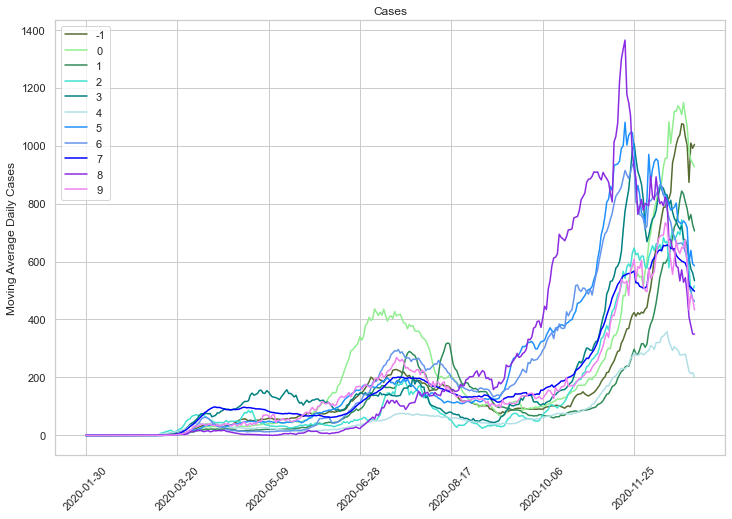

In [17]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

## K-means

In [18]:
#k-means
feature_dict, features = cluster_time_series(post_memo, cluster_method = 'kmeans')
colors = get_colors(len(feature_dict), picker = 2)


In [19]:
df = pd.DataFrame.drop_duplicates(pd.merge(features['cluster'].reset_index(), fips, 
                              how = 'right', on = ['county_state']))
group = df['fips']
values = df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

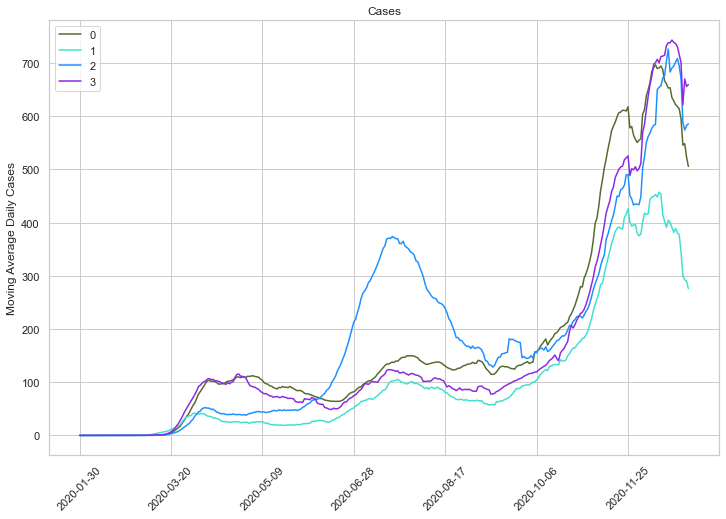

In [20]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

In [21]:

for key in feature_dict:
    print('In Group %s'%(key))
    last_day_case = uscounties_cases_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Population Adjusted Cases: Mean %s STD %s"%(last_day_case.mean(), last_day_case.std()))
    
    last_day_death = uscounties_deaths_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Population Adjusted Death: Mean %s STD %s"%(last_day_death.mean(), last_day_death.std()))
    
    print("Average temperature %s F "%(np.mean(post_memo[feature_dict[key]].mean())))
    
    print("\n")
    
    

In Group 0
Population Adjusted Cases: Mean 66668.37574823671 STD 24009.146094640106
Population Adjusted Death: Mean 1096.5284460482933 STD 747.420600155184
Average temperature 73.8533954684236 F 


In Group 1
Population Adjusted Cases: Mean 46791.804404486924 STD 25921.36386119473
Population Adjusted Death: Mean 507.95301000902106 STD 490.9326869747807
Average temperature 58.49510631477723 F 


In Group 2
Population Adjusted Cases: Mean 70423.55699127616 STD 25595.1626622561
Population Adjusted Death: Mean 1360.9418035811907 STD 896.8024625346634
Average temperature 78.74542183883862 F 


In Group 3
Population Adjusted Cases: Mean 58956.117249438335 STD 32115.23880457966
Population Adjusted Death: Mean 1051.2287368692876 STD 920.3739183759532
Average temperature 68.2267006802721 F 




## AgglomerativeClustering

In [22]:
feature_dict, features = cluster_time_series(post_memo, cluster_method = 'AgglomerativeClustering')
colors = get_colors(len(feature_dict), picker = 2)


In [23]:
df = pd.DataFrame.drop_duplicates(pd.merge(features['cluster'].reset_index(), fips, 
                              how = 'right', on = ['county_state']))
group = df['fips']
values = df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

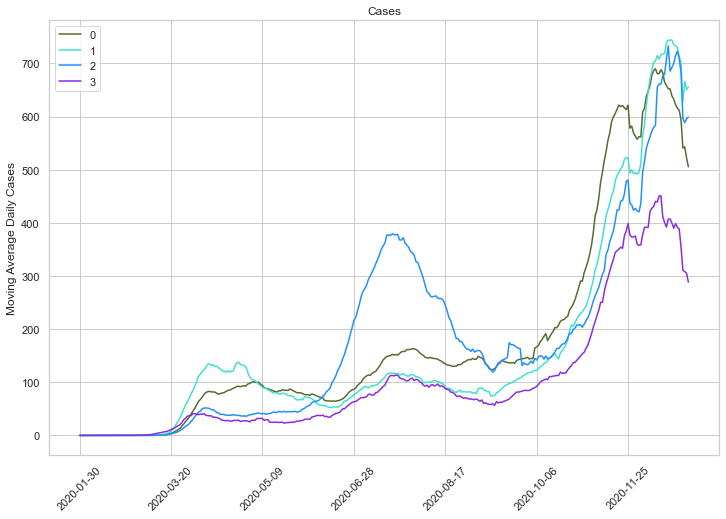

In [24]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

In [25]:

for key in feature_dict:
    print('In Group %s'%(key))
    last_day_case = uscounties_cases_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Population Adjusted Cases: Mean %s STD %s"%(last_day_case.mean(), last_day_case.std()))
    
    last_day_death = uscounties_deaths_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Population Adjusted Death: Mean %s STD %s"%(last_day_death.mean(), last_day_death.std()))
    
    print("Average temperature %s F "%(np.mean(post_memo[feature_dict[key]].mean())))
    
    print("\n")
    
    

In Group 0
Population Adjusted Cases: Mean 68299.91809433974 STD 24638.798170025697
Population Adjusted Death: Mean 1137.441003221487 STD 786.1329793502615
Average temperature 73.89220901843883 F 


In Group 1
Population Adjusted Cases: Mean 55952.98988618115 STD 30417.238729077366
Population Adjusted Death: Mean 987.2817405763129 STD 844.2541110937347
Average temperature 68.17192887737104 F 


In Group 2
Population Adjusted Cases: Mean 70066.05358750533 STD 26111.07647139921
Population Adjusted Death: Mean 1378.5906565582352 STD 922.7655730793623
Average temperature 79.13387138230607 F 


In Group 3
Population Adjusted Cases: Mean 43210.04727237737 STD 23926.32546461218
Population Adjusted Death: Mean 459.9865191875538 STD 441.8960025473736
Average temperature 58.103477840840476 F 




In [26]:
for key in feature_dict:
    feature_dict[key] = list(feature_dict[key])
np.save('temp_cluster.npy', feature_dict)

# State level

In [27]:
#df_sample = pd.read_csv('minoritymajority.csv') #use if the following line does not work
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
fips = df_sample[['FIPS', 'STNAME', 'CTYNAME']]

fips.columns = ['fips', 'state', 'county']

In [28]:
post_memo = state_temp_data.loc['2020-05-25':]
feature_dict, features = cluster_time_series(post_memo, cluster_method = 'kmeans')
colors = get_colors(len(feature_dict), picker = 2)


In [29]:
cluster_df = features['cluster'].reset_index()
cluster_df.columns = ['state', 'cluster']

fips.columns = ['fips', 'state', 'county']
cluster_df = pd.merge(cluster_df, fips, how = 'inner', on = 'state')

group = cluster_df['fips']
values = cluster_df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

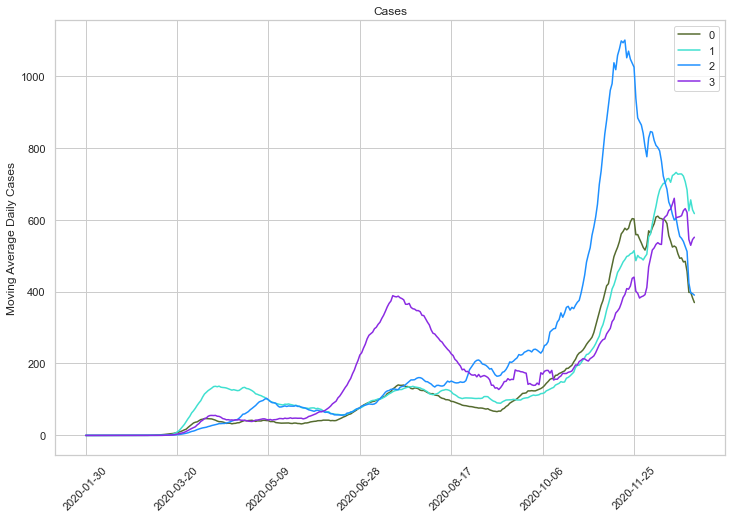

In [30]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

In [31]:
#Some descriptive information
for key in feature_dict:
    print('In Group %s'%(key))
    last_day_case = uscases_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day population adjusted Cases: Mean %s STD %s"%(last_day_case.mean(), last_day_case.std()))
    
    last_day_death = usdeaths_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day Population adjusted Death: Mean %s STD %s"%(last_day_death.mean(), last_day_death.std()))
    
    print("Average temperature %s F"%(np.mean(post_memo.iloc[:30][feature_dict[key]].mean())))
    
    print("\n")
    
    

In Group 0
Last day population adjusted Cases: Mean 50481.40537346268 STD 27304.374139148516
Last day Population adjusted Death: Mean 568.3604747583088 STD 266.62203769836
Average temperature 61.92530593232691 F


In Group 1
Last day population adjusted Cases: Mean 58419.722314268154 STD 14057.518570363944
Last day Population adjusted Death: Mean 1140.8669845989891 STD 480.0607877476421
Average temperature 69.39593164356866 F


In Group 2
Last day population adjusted Cases: Mean 85375.92250078986 STD 20133.462258092906
Last day Population adjusted Death: Mean 1149.0095147681886 STD 335.9162417820228
Average temperature 70.76104164977127 F


In Group 3
Last day population adjusted Cases: Mean 62964.04372070608 STD 9499.117865337807
Last day Population adjusted Death: Mean 1094.4342249596161 STD 278.43780973367666
Average temperature 76.57340203299314 F


